# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — она уже сделали.

Необходимо построить модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [3]:
pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 4.5 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.3.1 -> 23.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
import seaborn as sns

In [5]:
df = pd.read_csv('/Users/denismaslov/yandex_projects/yandex/sprint5/users_behavior.csv')

In [6]:
display(df.head(10))

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


Мы видим, что в таблице представлена информация о звонках, минутах, сообщений, использования интернета и типе тарифа.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Колонки показывающие количество звонков и сообщений приведем к типу int, так здесь должны быть целочисленные значения.

In [8]:
df['calls'] = df['calls'].astype("int")
df['messages'] = df['messages'].astype("int")

In [9]:
display(df.head(10))

,calls,minutes,messages,mb_used,is_ultra
0,40,311.90,83,19915.42,0
1,85,516.75,56,22696.96,0
2,77,467.66,86,21060.45,0
3,106,745.53,81,8437.39,1
4,66,418.74,1,14502.75,0
5,58,344.56,21,15823.37,0
6,57,431.64,20,3738.90,1
7,15,132.40,6,21911.60,0
8,7,43.39,3,2538.67,1
9,90,665.41,38,17358.61,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int64  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int64  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


Проверим данные на дубликаты.

In [11]:
df.duplicated().sum()

0

Дубликаты отсутствуют. В остальном данные готовы к работе.

/Users/denismaslov/Library/Python/3.10/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


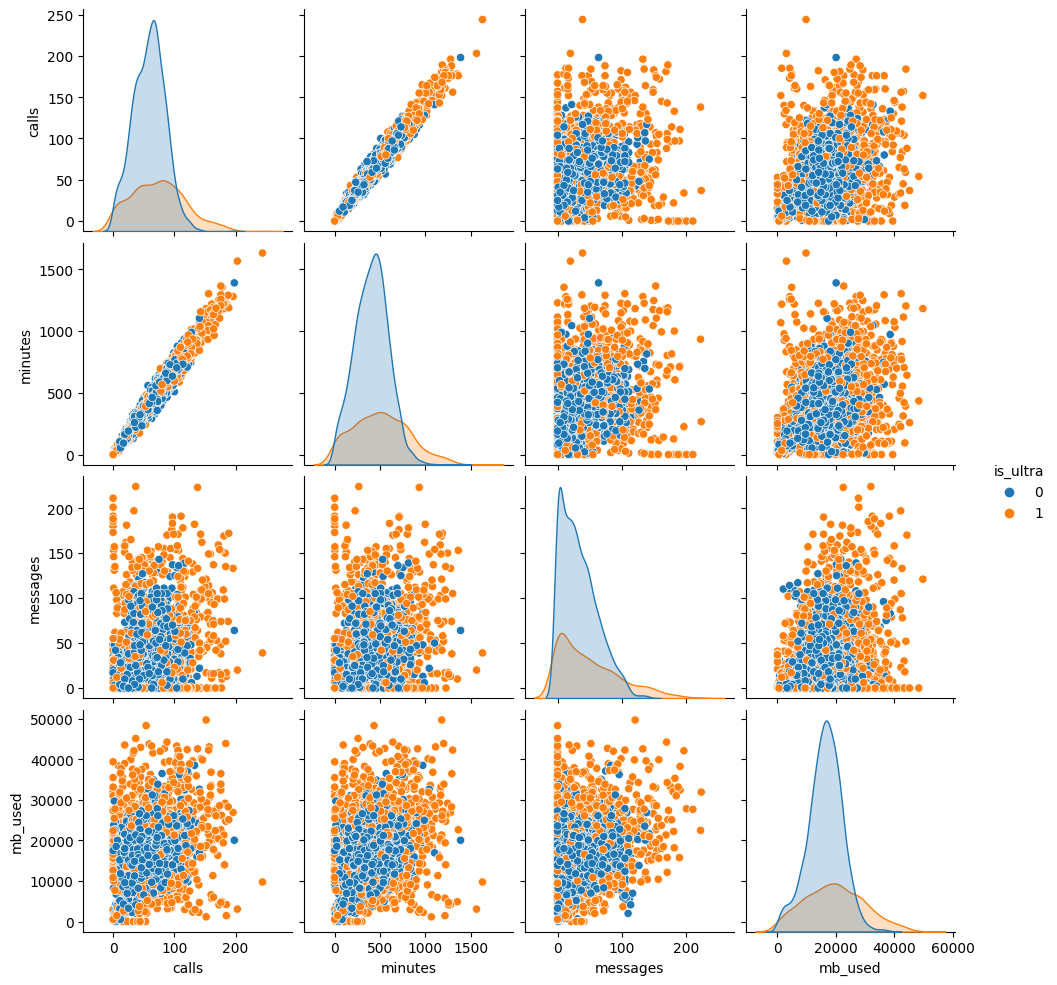

In [12]:
sns.pairplot (df, hue='is_ultra')

In [13]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


<div class="alert alert-block alert-warning">
<b>Изменения:</b> Парный график из библтотеки Seaborn построен. Из графиков видно, что есть четкая зависимость количества звонков и продолжительности разговоров. При этом абоненты на тарифе Ultra разговаривают больше чем абоненты на тарифе Smart. Остальные признаки имеют не высокую зависимость, но в тоже время, по всем признакам на тарифе Ultra расход услуг больше чем на тарифе Smart.
</div>

## Разбейте данные на выборки

### Создаем переменные с признаками и целевым признаком

In [14]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

### Разделим исходные данные

Разделим исходные данные на 3 выборки: Обучающую -60% и Тестовую - 40%

In [15]:
features_train, features_test_ad, target_train, target_test_ad = train_test_split(
   features, target, test_size=0.4, random_state=12345)

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Тестовую выборку в 40% будем использовать для тестирования наилучшей модели.
</div>

Тестовую выборку разделим также на 2 выборки: Валидационную - 50% и Тестовую - 50%.

In [16]:
features_test, features_valid, target_test, target_valid = train_test_split(
   features_test_ad, target_test_ad, test_size=0.5, random_state=12345)

Итак у нас получилось 3 выборки: Обучающая - 60%, Валидационная - 20%, Тестовая - 20% или в соотношении 3:1:1

In [17]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1928 entries, 3027 to 482
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     1928 non-null   int64  
 1   minutes   1928 non-null   float64
 2   messages  1928 non-null   int64  
 3   mb_used   1928 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 75.3 KB


## Исследуйте модели

### Дерево решений

In [18]:
best_model_tree = None
best_result_tree = 0
for depth in range(1, 11):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree.fit(features_train, target_train)
    predictions_valid_tree = model_tree.predict(features_valid)
    result_tree = accuracy_score(target_valid, predictions_valid_tree)
    print(f"max_depth = {depth} : {result_tree}")
    if result_tree > best_result_tree:
        best_model_tree = model_tree
        best_result_tree = result_tree
        
print(f"Accuracy наилучшей модели на валидационной выборке:{best_result_tree}")

max_depth = 1 : 0.7356143079315708
max_depth = 2 : 0.7744945567651633
max_depth = 3 : 0.7791601866251944
max_depth = 4 : 0.7744945567651633
max_depth = 5 : 0.7838258164852255
max_depth = 6 : 0.776049766718507
max_depth = 7 : 0.7993779160186625
max_depth = 8 : 0.7931570762052877
max_depth = 9 : 0.7807153965785381
max_depth = 10 : 0.7884914463452566
Accuracy наилучшей модели на валидационной выборке:0.7993779160186625


Accuracy наилучшей модели на алгоритме "Дерево решений" на валидационной выборке:0.7993779160186625 при максимальной глубине равной 7.

### Случайный лес

In [19]:
best_model_fr = None
best_result_fr = 0
for est in range(1, 11):
    model_fr = RandomForestClassifier(random_state=12345, n_estimators=est)
    model_fr.fit(features_train, target_train)
    predictions_valid_fr = model_fr.predict(features_valid)
    result_fr = accuracy_score(target_valid, predictions_valid_fr)
    print(f"max_est = {est} : {result_fr}")
    if result_fr > best_result_fr:
        best_model_fr = model_fr
        best_result_fr = result_fr

print("Accuracy наилучшей модели на валидационной выборке:", best_result_fr)

max_est = 1 : 0.7402799377916018
max_est = 2 : 0.7589424572317263
max_est = 3 : 0.7573872472783826
max_est = 4 : 0.7729393468118196
max_est = 5 : 0.7667185069984448
max_est = 6 : 0.7791601866251944
max_est = 7 : 0.7807153965785381
max_est = 8 : 0.7869362363919129
max_est = 9 : 0.7838258164852255
max_est = 10 : 0.7807153965785381
Accuracy наилучшей модели на валидационной выборке: 0.7869362363919129


Accuracy наилучшей модели на алгоритме "Случайный лес" на валидационной выборке: 0.7869362363919129 при количестве деревьев 8.

### Логистическая регрессия

In [20]:
model_log = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model_log.fit(features_train, target_train)
predictions_valid_log = model_log.predict(features_valid)
result_log = accuracy_score(target_valid, predictions_valid_log)
print("Accuracy наилучшей модели на валидационной выборке:", result_log)

Accuracy наилучшей модели на валидационной выборке: 0.6842923794712286


Accuracy наилучшей модели на алгоритме "Логистическая регрессия" на валидационной выборке: 0.6842923794712286

Выводы:<br>
<li>Мы провели обучение моделей по 3 алгоритмам и выявили, что лучшая метрика качества (Accuracy) у модели на алгоритме "Дерево решений" на валидационной выборке равна 0.7993779160186625 при максимальной глубине 7. Ее и будем использовать.

## Проверьте модель на тестовой выборке

Объединим тренировочную и валидационную выборку и проведем обучение модели на ней.


In [21]:
new_features_train = pd.concat([features_train, features_valid], axis=0, ignore_index=True)
new_target_train = pd.concat([target_train, target_valid], axis=0, ignore_index=True)

In [22]:
model = DecisionTreeClassifier(random_state=12345, max_depth=7)
model.fit(new_features_train, new_target_train)
predictions_test = best_model_tree.predict(features_test)
result_test = accuracy_score(target_test, predictions_test)
print("Accuracy модели на тестовой выборке:", result_test)

Accuracy модели на тестовой выборке: 0.7822706065318819


При проверке модели на тестовой выборке, мы получили accuracy = 0.7822706065318819, что чуть ниже, чем результат полученный на валидационной выборке.

При тестировании использована обьединенная валидационная и тестовая выборка. Действительно качество чуть возросло до 0.7908242612752722


## (бонус) Проверьте модели на адекватность

При создании модели машинного обучения для какого-либо проекта разумно сначала создать baseline модель. Она представляет собой простейшую (dummy) модель, которая всегда предсказывает наиболее часто встречающийся класс. Так вы получите контрольные данные для сравнительной оценки построенной вами более сложной модели. К тому же вы сможете быть уверены в качестве ее работы, например, в том, что она выдает не просто набор случайно подобранных данных.
В библиотеке scikit-learn есть DummyClassifier() для задач классификации и DummyRegressor() для работы с регрессией. Мы и возьмем этот алгоритм.

In [24]:
model_dm = DummyClassifier(strategy='most_frequent', random_state=12345)
model_dm.fit(features_train, target_train)
predictions_dm = model_dm.predict(features_valid)
result_dm = accuracy_score(target_valid, predictions_dm)
print('Accuracy DummyClassifier:', result_dm)

Accuracy DummyClassifier: 0.6842923794712286


Мы видим, что accuracy у модели на алгоритме DummyClassifier равна 0.6842923794712286, что ниже чем у модели на алгоритме "Дерево решений" на тестовой выборке, в следствие чего мы можем сделать вывод, что наша модель адекватна.

## Заключение

В нашем распоряжении были данные о поведении клиентов, которые уже перешли на тарифы «Смарт» или «Ультра».
<li>При рассмотрении данных были приведены колонки с информацией о количестве звонков и сообщений к типу int.</li>
<li>Были созданы переменные с признаками и целевым признаком</li>
<li>Датафрейм был разделен на обучающую, валидационную и тестовую выборки в соотношении 3:1:1</li>
<li>Были исследованы 3 различных алгоритма моделей "Дерево решений", "Случайный лес" и "Логистическая регрессия" с различными гиперпараметрами. Наилучшей оказалась модель на алгоритме "Дерево решений" на валидационной выборке. Accuracy получилась 0.7993779160186625 при максимальной глубине 7</li>
<li>Лучшая модель была проверена на тестовой выборке и получено значение accuracy равной 0.7822706065318819, что чуть ниже, чем результат полученный на валидационной выборке</li>
<li>Была проведена проверка модели на адекватность, путем сравнения результата нашей модели с результатом модели на алгоритме DummyClassifier. Проверка показала, что наша модель адекватна.</li>